In [70]:
import pandas as pd
import seaborn as sns
from pyxlsb import open_workbook, convert_date
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import plot_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,f1_score,accuracy_score,roc_auc_score,precision_score, confusion_matrix, recall_score, classification_report

In [2]:
#function to read binary excel file and return dataframe
def readExcelFile(filepath):
    temp_datalist=[]
    with open_workbook(filepath) as wb:
        with wb.get_sheet(1) as sheet:
            for row in sheet.rows():
                try:
                    temp_datalist.append([item.v for item in row])
                except Exception as e:
                    print(e)
    tempdf = pd.DataFrame(temp_datalist[1:], columns=temp_datalist[0])
    return tempdf


In [3]:
#Training Dataframe
df = readExcelFile(r"Shipment_performance_Train__Data.xlsb")

In [41]:
#Test Dataframe
df_test = readExcelFile(r"Shipment_performance_Test__Data.xlsb")

<h4>EDA Part</h4>

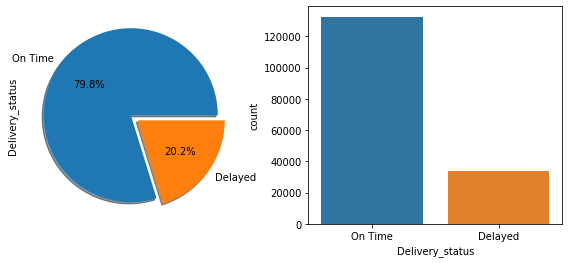

In [5]:
f, ax = plt.subplots(1,2,figsize=(10,4))

df['Delivery_status'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True
)

sns.countplot('Delivery_status', data=df, ax=ax[1])

plt.show()

From above chart it is clearly shown that our dataset is imbalance (Class imbalance).

In [6]:
#combining train and test set for preprocessing step
df["test"] = 0
df_test["test"] = 1
all_data = pd.concat([df, df_test], axis=0, join='outer') 

In [7]:
#checking for Null values in our entire dataset
all_data.isnull().sum()

Shipment_id             0
Start_date              0
End_Date                0
Start_city              0
End_city                0
Start_city_latitude     0
Start_city_longitude    0
End_city_latitude       0
End_city_longitude      0
Delivery_status         0
test                    0
dtype: int64

In [8]:
#converting float start_date and End_date into datetime formate
all_data["converted_StartDate"] = all_data.Start_date.apply(lambda x: convert_date(x))
all_data["converted_EndDate"] = all_data.End_Date.apply(lambda x: convert_date(x))

In [ ]:
#getting number of days took to complete delivery process
#df["NumberOfDays"] = (df['converted_EndDate'] - df['converted_StartDate']).dt.days

In [9]:
#Seprating year, month , day, hour, minute from given datatime
all_data['year'] = all_data['converted_StartDate'].dt.year
all_data['month'] = all_data['converted_StartDate'].dt.month
all_data['day'] = all_data['converted_StartDate'].dt.day
all_data['hour'] = all_data['converted_StartDate'].dt.hour
all_data['minute'] = all_data['converted_StartDate'].dt.minute


In [ ]:
all_data.head()

In [10]:
#Getting week day name for given date
week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def getweekDayname(x):
    #print(x.weekday())
    return x.weekday()

all_data["weekday"] = all_data.converted_StartDate.apply(lambda x: week[getweekDayname(x)])

Here we will be following 2 approaches for building our model.<br>
1) We will be using lat, long coordinates as input. <br>
2) We will be using start and end city name as input. <br>
Main idea is to test accuracy of these 2 approaches.

In [11]:
df_train1 = all_data[["Start_city_latitude","Start_city_longitude","End_city_latitude","End_city_longitude","Delivery_status","month",
               "day","hour","weekday"]][all_data["test"]==0]

df_train2 = all_data[["Start_city","End_city","Delivery_status","month","day","hour","weekday"]][all_data["test"]==0]

In [12]:
test_data1 = all_data[["Start_city_latitude","Start_city_longitude","End_city_latitude","End_city_longitude","Delivery_status","month",
               "day","hour","weekday"]][all_data["test"]==1]

test_data2 = all_data[["Start_city","End_city","Delivery_status","month","day","hour","weekday"]][all_data["test"]==1]

In [13]:
#functon to convert str or object datatypes into category type so that it can be easily consume by Algorithm.
def convertCategory(dataframe):
    for c in dataframe.columns:
        col_type = dataframe[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            dataframe[c] = dataframe[c].astype('category')
    return dataframe

In [14]:
df_train1 = convertCategory(df_train1)
test_data1 = convertCategory(test_data1)

df_train2 = convertCategory(df_train2)
test_data2 = convertCategory(test_data2)

Genralisation of model using lat, long coordinates as feature.

In [15]:
#Label encoding of Target variable.
le = LabelEncoder()
df_train1["Delivery_status"] = le.fit_transform(df_train1["Delivery_status"])
#test_data["Delivery_status"] = le.fit_transform(test_data["Delivery_status"])

In [16]:
#creating dependent and independent features
y_train1 = df_train1["Delivery_status"]
X_train1 = df_train1.drop(["Delivery_status"], axis=1)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

# X_train1 = sc.fit_transform(X_train1)
# y_train1 = sc.transform(y_train1)

Since we have a class imbalance dataset and we have a good amount of dataset hence we will be using LGBM (LightGBM).

In [17]:
#Hyperparameters for LGBM
opt_params={'bagging_fraction': 0.83,
 'feature_fraction': 0.1,
 'learning_rate': 0.09,
 'max_bin': 20,
 'max_depth': 23,
 'min_data_in_leaf': 20,
 #'min_sum_hessian_in_leaf': 100.0,
 'num_leaves': 80,
 'subsample': 0.03,
 'objective': 'binary',
 'metric': 'auc',
 'reg_lambda' : 0.02,
 'is_unbalance': True,
 'boost_from_average': False}

We will be using StratifiedKFold cross validaton techinque because in case of imbalance dataset StratifiedKFold consider 
class imbalance while creating Folds of dataset. 

In [18]:
#First Model Training. 
modelresult1 = np.zeros(len(X_train1)) # store model prediction
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
model1 = lgb.LGBMClassifier(**opt_params,n_estimators=8000)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train1, y_train1)):
    print("Fold {}".format(fold_))
    X_train = X_train1.iloc[trn_idx,:]
    y_train = y_train1.iloc[trn_idx]
    X_test = X_train1.iloc[val_idx,:]
    y_test = y_train1.iloc[val_idx]
    model1.fit(X_train, y_train, eval_set=(X_test, y_test),  categorical_feature = 'auto', verbose=500, early_stopping_rounds = 250)
    modelresult1[val_idx] = model1.predict(X_train1.iloc[val_idx,:], num_iteration=model1.best_iteration_)
    
print("CV score: {:<8.5f}".format(roc_auc_score(y_train1, modelresult1)))

Fold 0
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.831789
[1000]	valid_0's auc: 0.832848
[1500]	valid_0's auc: 0.833269
[2000]	valid_0's auc: 0.833499
[2500]	valid_0's auc: 0.833601
[3000]	valid_0's auc: 0.833648
[3500]	valid_0's auc: 0.83368
[4000]	valid_0's auc: 0.833694
[4500]	valid_0's auc: 0.833695
Early stopping, best iteration is:
[4479]	valid_0's auc: 0.833695
Fold 1
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.82728
[1000]	valid_0's auc: 0.828365
[1500]	valid_0's auc: 0.828818
[2000]	valid_0's auc: 0.829047
[2500]	valid_0's auc: 0.829162
[3000]	valid_0's auc: 0.829225
[3500]	valid_0's auc: 0.82926
[4000]	valid_0's auc: 0.829278
[4500]	valid_0's auc: 0.82929
[5000]	valid_0's auc: 0.829303
[5500]	valid_0's auc: 0.829307
[6000]	valid_0's auc: 0.829309
[6500]	valid_0's auc: 0.829312
[7000]	valid_0's auc: 0.829315
[7500]	valid_0's auc: 0.829317
[8000]	valid_0's auc: 0.829321
Did not meet early stopping

In [19]:
#Testing our model on Test Data 
test_data1["Delivery_status"] = le.fit_transform(test_data1["Delivery_status"])
y_test1 = test_data1["Delivery_status"]
X_test1 = test_data1.drop(["Delivery_status"], axis=1)
y_test_pred1 = model1.predict(X_test1)
y_pred1 = y_test_pred1.round(0)
y_pred1 = y_pred1.astype(int)

print("F1 Score of model1 using coordinates as features: {:<8.5f}".format(f1_score(y_test1, y_pred1)))
print("Recall Score of model1 using coordinates as features: {:<8.5f}".format(recall_score(y_test1, y_pred1)))
print("Precision Score of model1 using coordinates as features: {:<8.5f}".format(precision_score(y_test1, y_pred1)))
print("Accuracy of model1 using coordinates as features: {:<8.5f}".format(accuracy_score(y_test1, y_pred1)))



F1 Score of model1 using coordinates as features: 0.81336 
Recall Score of model1 using coordinates as features: 0.79388 
Precision Score of model1 using coordinates as features: 0.83383 
Accuracy of model1 using coordinates as features: 0.71378 


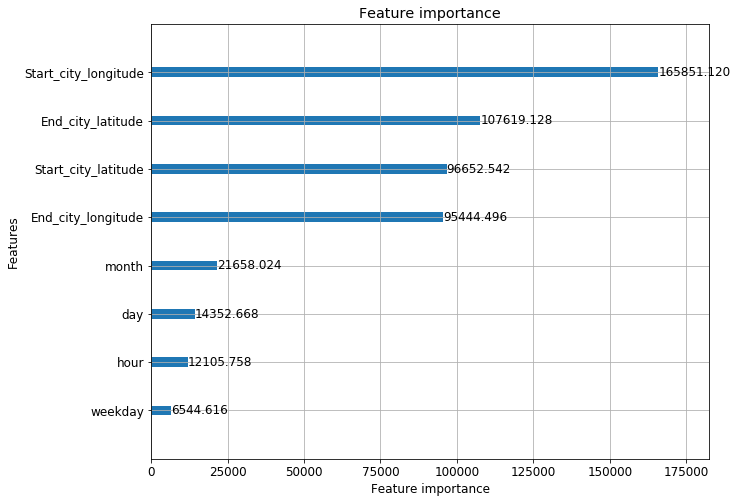

In [20]:
# plotting the feature importance

# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

# like other tree-based models, it can also output the
# feature importance plot
plot_importance(model1, importance_type='gain')
plt.show()

Genralisation of model using start and end cityname as feature.

In [21]:
#Label encoding of Target variable.
df_train2["Delivery_status"] = le.fit_transform(df_train2["Delivery_status"])

#creating dependent and independent features
y_train2 = df_train2["Delivery_status"]
X_train2 = df_train2.drop(["Delivery_status"], axis=1)

In [22]:
modelresult2 = np.zeros(len(X_train2)) # store model prediction
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31416)
model2 = lgb.LGBMClassifier(**opt_params,n_estimators=8000)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train2, y_train2)):
    print("Fold {}".format(fold_))
    X_train = X_train2.iloc[trn_idx,:]
    y_train = y_train2.iloc[trn_idx]
    X_test = X_train2.iloc[val_idx,:]
    y_test = y_train2.iloc[val_idx]
    model2.fit(X_train, y_train, eval_set=(X_test, y_test),  categorical_feature = 'auto', verbose=500, early_stopping_rounds = 250)
    modelresult2[val_idx] = model2.predict(X_train2.iloc[val_idx,:], num_iteration=model2.best_iteration_)
print("CV score: {:<8.5f}".format(roc_auc_score(y_train2, modelresult2)))

Fold 0
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.891467
Early stopping, best iteration is:
[485]	valid_0's auc: 0.89154
Fold 1
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.883401
Early stopping, best iteration is:
[478]	valid_0's auc: 0.883511
Fold 2
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.882848
Early stopping, best iteration is:
[553]	valid_0's auc: 0.882953
Fold 3
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.884148
Early stopping, best iteration is:
[587]	valid_0's auc: 0.884237
Fold 4
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.885519
Early stopping, best iteration is:
[466]	valid_0's auc: 0.885591
Fold 5
Training until validation scores don't improve for 250 rounds
[500]	valid_0's auc: 0.886174
Early stopping, best iteration is:
[589]	valid_0's auc: 0.886299
Fold 6
Training u

In [23]:

test_data2["Delivery_status"] = le.fit_transform(test_data2["Delivery_status"])
#test_data["Delivery_status"] = le.fit_transform(test_data["Delivery_status"])

#creating dependent and independent features
y_test2 = test_data2["Delivery_status"]
X_test2 = test_data2.drop(["Delivery_status"], axis=1)
y_test_pred2 = model2.predict(X_test2)

In [24]:
y_pred2 = y_test_pred2.round(0)
y_pred2 = y_pred2.astype(int)

print("F1 Score of model2 using coordinates as features: {:<8.5f}".format(f1_score(y_test2, y_pred2)))
print("Recall Score of model2 using coordinates as features: {:<8.5f}".format(recall_score(y_test2, y_pred2)))
print("Precision Score of model2 using coordinates as features: {:<8.5f}".format(precision_score(y_test2, y_pred2)))
print("Accuracy of model2 using coordinates as features: {:<8.5f}".format(accuracy_score(y_test2, y_pred2)))

F1 Score of model2 using coordinates as features: 0.74097 
Recall Score of model2 using coordinates as features: 0.62765 
Precision Score of model2 using coordinates as features: 0.90422 
Accuracy of model2 using coordinates as features: 0.65524 


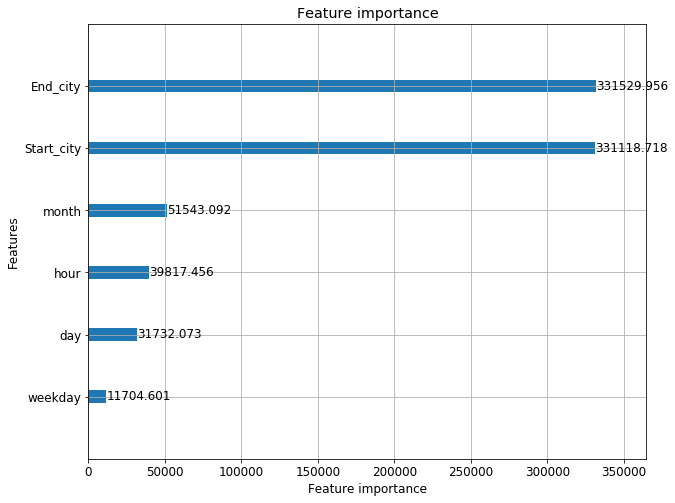

In [25]:
# plotting the feature importance
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

# feature importance plot
plot_importance(model2, importance_type='gain')
plt.show()


Since model1 outperform model2 we will store Model1 in Pickel format

In [26]:
import pickle
filename = r"mahinLog.pkl"
pickle.dump(model1, open(filename, 'wb'))

In [27]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test1, y_test1)
print(result)

0.7137765819349052


In [28]:
pred_class = le.inverse_transform(y_pred1)
pred_class

array(['On Time', 'On Time', 'On Time', ..., 'On Time', 'On Time',
       'On Time'], dtype=object)

In [43]:
df_test["Predicted status"] = pred_class


In [39]:
df_test.drop(["prob_Delay","prob_Ontime","test"],axis=1, inplace=True)

In [47]:
#x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
prob1 = model1.predict_proba(X_test1)
prodf = pd.DataFrame(prob1, columns=["prob_Delay","prob_Ontime"])


In [64]:
df_test["Prob_ontime"] = prodf["prob_Ontime"]
df_test["Prob_Delay"] = prodf["prob_Delay"]
df_test.head(50)

,Shipment_id,Start_date,End_Date,Start_city,End_city,Start_city_latitude,Start_city_longitude,End_city_latitude,End_city_longitude,Delivery_status,Predicted status,Prob_ontime,Prob_Delay
0,VHC 31820052,43864.913194,43865.436806,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.996163,0.003837
1,VHC 31820216,43865.000000,43867.454167,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,Delayed,On Time,0.998324,0.001676
2,VHC 31820422,43865.000000,43866.750000,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998324,0.001676
3,VHC 31820498,43865.000000,43867.457639,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,Delayed,On Time,0.998324,0.001676
4,VHC 31820522,43865.000000,43866.790972,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998324,0.001676
5,VHC 31820780,43865.000000,43866.790972,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998324,0.001676
6,VHC 31820810,43865.000000,43866.790972,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998324,0.001676
7,VHC 31832944,43865.610417,43866.790972,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998768,0.001232
8,VHC 31833440,43865.652083,43866.422917,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998644,0.001356
9,VHC 31852432,43866.000000,43867.770833,Dolvi,Khopoli,18.691254,73.039795,18.789499,73.344803,On Time,On Time,0.998874,0.001126


In [65]:
print(confusion_matrix(y_pred1,y_pred1))

[[ 3817  6861]
 [ 5266 26425]]


In [66]:
print(confusion_matrix(y_pred2,y_test2))

[[ 6870 12394]
 [ 2213 20892]]


In [67]:
df_test.to_csv(r"submission.csv", index=False)

In [68]:
resultdict = {"f1 score":f1_score(y_test1, y_pred1),
         "recall score" :recall_score(y_test1, y_pred1),
         "precision score" : precision_score(y_test1, y_pred1),
         "accuracy score": accuracy_score(y_test1, y_pred1)}

resultdict

{'f1 score': 0.8133647290579744,
 'recall score': 0.7938773057741993,
 'precision score': 0.8338329494178158,
 'accuracy score': 0.7137765819349052}

In [69]:
#Writing model score in json file 
import json

with open(r"result.json", "w") as outfile:
    json.dump(resultdict, outfile)

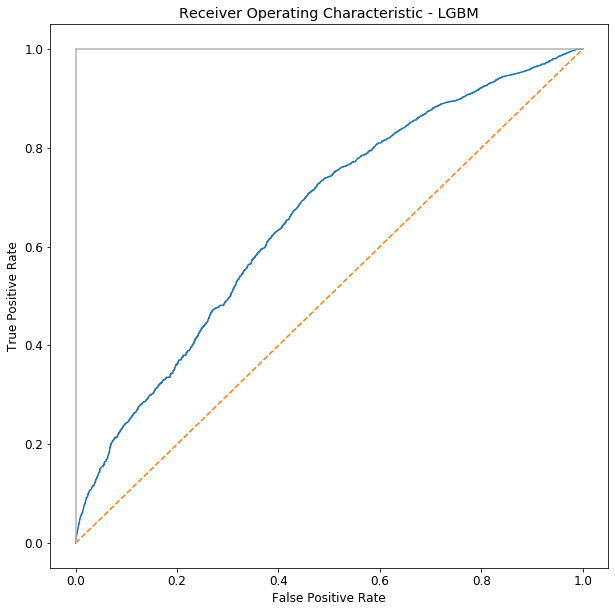

In [72]:
#plotting roc curve
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test2, prodf[prob_Ontime])
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - LGBM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()